In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
from latent_rnn import create_LatentODE_model

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [5]:
obsrv_std = torch.Tensor([0.1]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std).to(device)

In [6]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load('latent_ode_state.pth.tar', map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=22, out_features=10, bias=True)
        (1): Tanh()
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=22, out_features=10, bias=True)
        (1): Tanh()
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=22, out_features=10, bias=True)
        (1): Tanh()
        (2): Linear(in_features=10, out_features=20, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=10, out_features=20, bias=True)
          (1): Tanh()
          (2): Linear(in_features=20, out_features=20, bias=True)
          (3): Tanh()
          (4): Linear(in_fea

In [9]:
loader = torch.load('ucr_train_extrap.pt')

## Inference

In [10]:
def sample(z, t):
    sol_y = model.diffeq_solver.sample_traj_from_prior(z, t, n_traj_samples = 1)
    out = model.decoder(sol_y)
    return out

In [11]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
rec_mins = []
rec_maxs = []
rec_stds = []
samples = []
for batch in tqdm(loader):
    observed = batch['observed_data'].to(device)
    true = batch['data_to_predict'].to(device)
    truths.extend([x for x in true])
    mask = batch['observed_mask'].to(device)
    mask_pred = batch['mask_predicted_data']#.to(device)
#     mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
#     if not mask_pred:
#         mask_pred = torch.ones(true.shape)
    mask_pred = mask_pred.to(device)
    x2 = torch.cat((true, mask_pred), -1)
    t1 = batch['observed_tp'].to(device)
    t2 = batch['tp_to_predict'].to(device)
    t = torch.cat([t1,t2])
#     truth_time_steps = t[mask.nonzero()]
#     ts.append(t.detach().cpu())
    z_u, z_std = model.encoder_z0.forward(x, t1)
    rec = model.get_reconstruction(
        time_steps_to_predict=t, truth=observed, truth_time_steps=t1, mask=mask, n_traj_samples=50)[0].detach().cpu().squeeze()
    rec_u = rec.mean(dim=0)
    rec_max = rec.max(dim=0)
    rec_min = rec.min(dim=0)
    rec_std = rec.std(dim=0)
    recs.extend([x for x in rec_u])
    rec_stds.extend([x for x in rec_std])
#     z_u = z_u.squeeze()
    s = sample(z_u, t)[0]
    samples.extend([x for x in s])
    z_u = z_u.detach().cpu()
    z_std = z_std.detach().cpu()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


In [56]:
len(rec_stds)

100

In [12]:
ix = 12

In [13]:
# y = samples[ix].detach().cpu().numpy().reshape(1,-1)
y = recs[ix].numpy().reshape(1,-1)
x = t.detach().cpu().numpy().reshape(1,-1)
y_true = truths[ix].detach().cpu().numpy().reshape(1,-1)

In [14]:
d_predict = np.concatenate([x, y], axis=0).T
d_true = np.concatenate([x[:,25:], y_true], axis=0).T

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 103 and the array at index 1 has size 64

In [ ]:
df_predict = pd.DataFrame(d_predict, columns = ['t', 'value'])
df_predict['type'] = 'prediction'
df_truth = pd.DataFrame(d_true, columns = ['t', 'value'])
df_truth['type'] = 'truth'
df = pd.concat([df_predict, df_truth], 0)

In [ ]:
sns.scatterplot(x='t', y='value', data=df, hue='type')

In [ ]:
break

### Plot Multiple

In [25]:
loader = torch.load('ucr_train_extrap.pt')

In [26]:
batch = next(iter(loader))

In [92]:
ix = 2

In [93]:
y1 = batch['observed_data'][ix].unsqueeze(0).to(device)
y2 = batch['data_to_predict'][ix].unsqueeze(0).to(device)
mask = batch['observed_mask'][ix].unsqueeze(0).to(device)
t1 = batch['observed_tp'].to(device)
t2 = batch['tp_to_predict'].to(device)

In [94]:
y1.shape

torch.Size([1, 64, 1])

In [95]:
rec = model.get_reconstruction(
    time_steps_to_predict=t2, 
    truth=y1, 
    truth_time_steps=t1, 
    mask=mask, 
    n_traj_samples=1000)[0].detach().cpu().squeeze()

In [96]:
rec.max(0)[0]

tensor([-0.5287, -0.5009, -0.4742, -0.4486, -0.4240, -0.4007, -0.3784, -0.3574,
        -0.3376, -0.3190, -0.3012, -0.2753, -0.2405, -0.2065, -0.1742, -0.1444,
        -0.1179, -0.0951, -0.0764, -0.0619, -0.0518, -0.0458, -0.0437, -0.0450,
        -0.0403, -0.0137,  0.0126,  0.0421,  0.0711,  0.0997,  0.1276,  0.1539,
         0.1777,  0.1985,  0.2159,  0.2300,  0.2468,  0.2678,  0.2878,  0.3065,
         0.3240,  0.3401,  0.3548,  0.3681,  0.3800,  0.3905,  0.3997,  0.4077,
         0.4153,  0.4336,  0.4503,  0.4652,  0.4780,  0.4888,  0.4975,  0.5044,
         0.5145,  0.5350,  0.5546,  0.5733,  0.5910,  0.6077,  0.6233,  0.6378])

In [97]:
u = rec.mean(dim=0).detach().cpu().numpy()
maxs = rec.max(dim=0)[0].detach().cpu().numpy()
mins = rec.min(dim=0)[0].detach().cpu().numpy()
recs = rec.detach().cpu().numpy()
y1 = y1.squeeze().detach().cpu().numpy()
y2 = y2.squeeze().detach().cpu().numpy()
t1 = t1.detach().cpu().numpy()
t2 = t2.detach().cpu().numpy()

In [98]:
plt.style.use('seaborn-darkgrid')
font = {'family': 'serif',
        'color':  'grey',
        'weight': 'light',
        'size': 12,
        }

In [99]:
# https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars

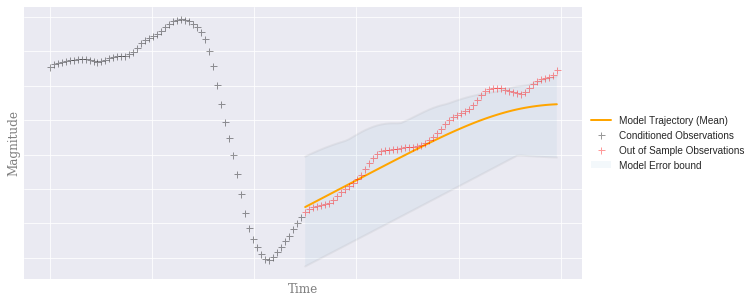

In [102]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
# for i, r in enumerate(recs):
#     if i == 0:
#         ax.plot(t2, r, marker='', color='grey', linewidth=1, alpha=0.4, label='Sampled Trajectories')
#     ax.plot(t2, r, marker='', color='grey', linewidth=1, alpha=0.4)
ax.plot(t2, u, marker='', color='orange', linewidth=2, alpha=1, label='Model Trajectory (Mean)')
ax.plot(t2, maxs, marker='', color='grey', linewidth=2, alpha=0.1)
ax.plot(t2, mins, marker='', color='grey', linewidth=2, alpha=0.1)
ax.plot(t1, y1, marker='+', color='black', linestyle='None', alpha=0.4, markersize=7, label='Conditioned Observations')
ax.plot(t2, y2, marker='+', color='red', linestyle='None', alpha=0.4, markersize=7, label='Out of Sample Observations')
plt.xlabel("Time", fontdict=font)
plt.ylabel("Magnitude", fontdict=font)
plt.fill_between(t2, mins, maxs, alpha=0.05, label='Model Error bound')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),
          ncol=1, fancybox=True, shadow=True)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False,
    right=False, 
    left=False)
